In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from data import load_train_data, load_test_data,plot_imagesT
import pdb
from skimage.io import imsave, imread
import cv2
import pickle
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import data
import pylab
import imageio
import matplotlib.pyplot as plt
#from  gen_data import load_image,random_batch,test_batch,load_images
from  get_resUnet import *
import params 
from os.path import splitext
from keras.utils import plot_model
from pathlib import Path
#import dask.array as da
#from dask.delayed import delayed
from dataloaders import *

In [4]:
netparam=params.init() 
netprameval=params.init(train=0) 


{'img_rows': 224, 'img_cols': 224, 'network': 'MulResNet', 'task': 'all', 'loss': 'CE', 'lr': 0.0001, 'optimizer': 'adam', 'batch_size': 10, 'epoch_size': 1, 'CLAHE': False, 'nb_epoch': 40, 'cycle_start_epoch': 23, 'predict_batch_size': 5, 'CROP': False, 'Flip': False, 'perspective': False, 'lighting': False, 'affine': False, 'randcrop': False, 'dbg': False, 'save_images': True, 'include_top': False, 'weights': 'imagenet', 'data_path': 'C:/Users/ianre/Desktop/coda/streoscene/Knot_Tying/images_pre/Knot_Tying_S02_T01', 'data_path_test': 'C:/Users/ianre/Desktop/coda/streoscene/Knot_Tying/images_pre/Knot_Tying_S02_T02'}


In [5]:
data.create_train_data(netparam)
data.create_test_data(netparam)

Training set already exists and loaded from file
Test set already exists and loaded from file


In [6]:
netparam.task

'all'

In [7]:
imgs_train, imgs_mask_train=data.load_train_data()
imgs_test,  imgs_mask_test =data.load_test_data()
train_setT=np.shape(imgs_train)

In [8]:
imgs_test[100]

array(['C:/Users/ianre/Desktop/coda/streoscene/Datasets/dV/Needle_Passing\\Needle_Passing_S02_T01\\left_frames\\frame_1568.png',
       'C:/Users/ianre/Desktop/coda/streoscene/Datasets/dV/Needle_Passing\\Needle_Passing_S02_T01\\right_frames\\frame_1568.png'],
      dtype='<U118')

In [9]:
imgs_mask_test[100]

'C:/Users/ianre/Desktop/coda/streoscene/Datasets/dV/Needle_Passing\\Needle_Passing_S02_T01\\ground_truth\\frame_1568.png'

In [10]:
np.random.seed(1234)
ids_train = np.random.choice(len(imgs_train), size=len(imgs_train), replace=False)
ids_val = np.random.choice(len(imgs_test), size=len(imgs_test), replace=False)

In [11]:
x=[[1,3],[2,5],[4,8],[6,7]]
d1=str(x[3][0])
d2=str(x[3][1])

In [12]:
ids_train=[i for i, s in enumerate(imgs_mask_train) if 'instrument_dataset_'+d1  not in s and 'instrument_dataset_'+d2  not in s]
ids_val = [i for i, s in enumerate(imgs_mask_test) if 'instrument_dataset_'+d1   in s or 'instrument_dataset_'+d2   in s]

In [13]:
print("Data Information: Evaluation on %s and %s"% (d1,d2))
print("------")
print("  - No of Frames in Training set: %d" % len(ids_train))
print("  - No of Frames in Test set %d" % len(ids_val))

Data Information: Evaluation on 6 and 7
------
  - No of Frames in Training set: 211
  - No of Frames in Test set 0


In [14]:
len(imgs_train)

211

In [15]:
datagen = CustomImageDataGenerator(netparam, training =0)

trainflow=datagen.flow(imgs_train, imgs_mask_train, batch_size=8)

In [16]:
x_batch,x_batch_right, y_batch,_ = trainflow.next()

In [17]:
y_batch.shape

(8, 224, 224, 3)

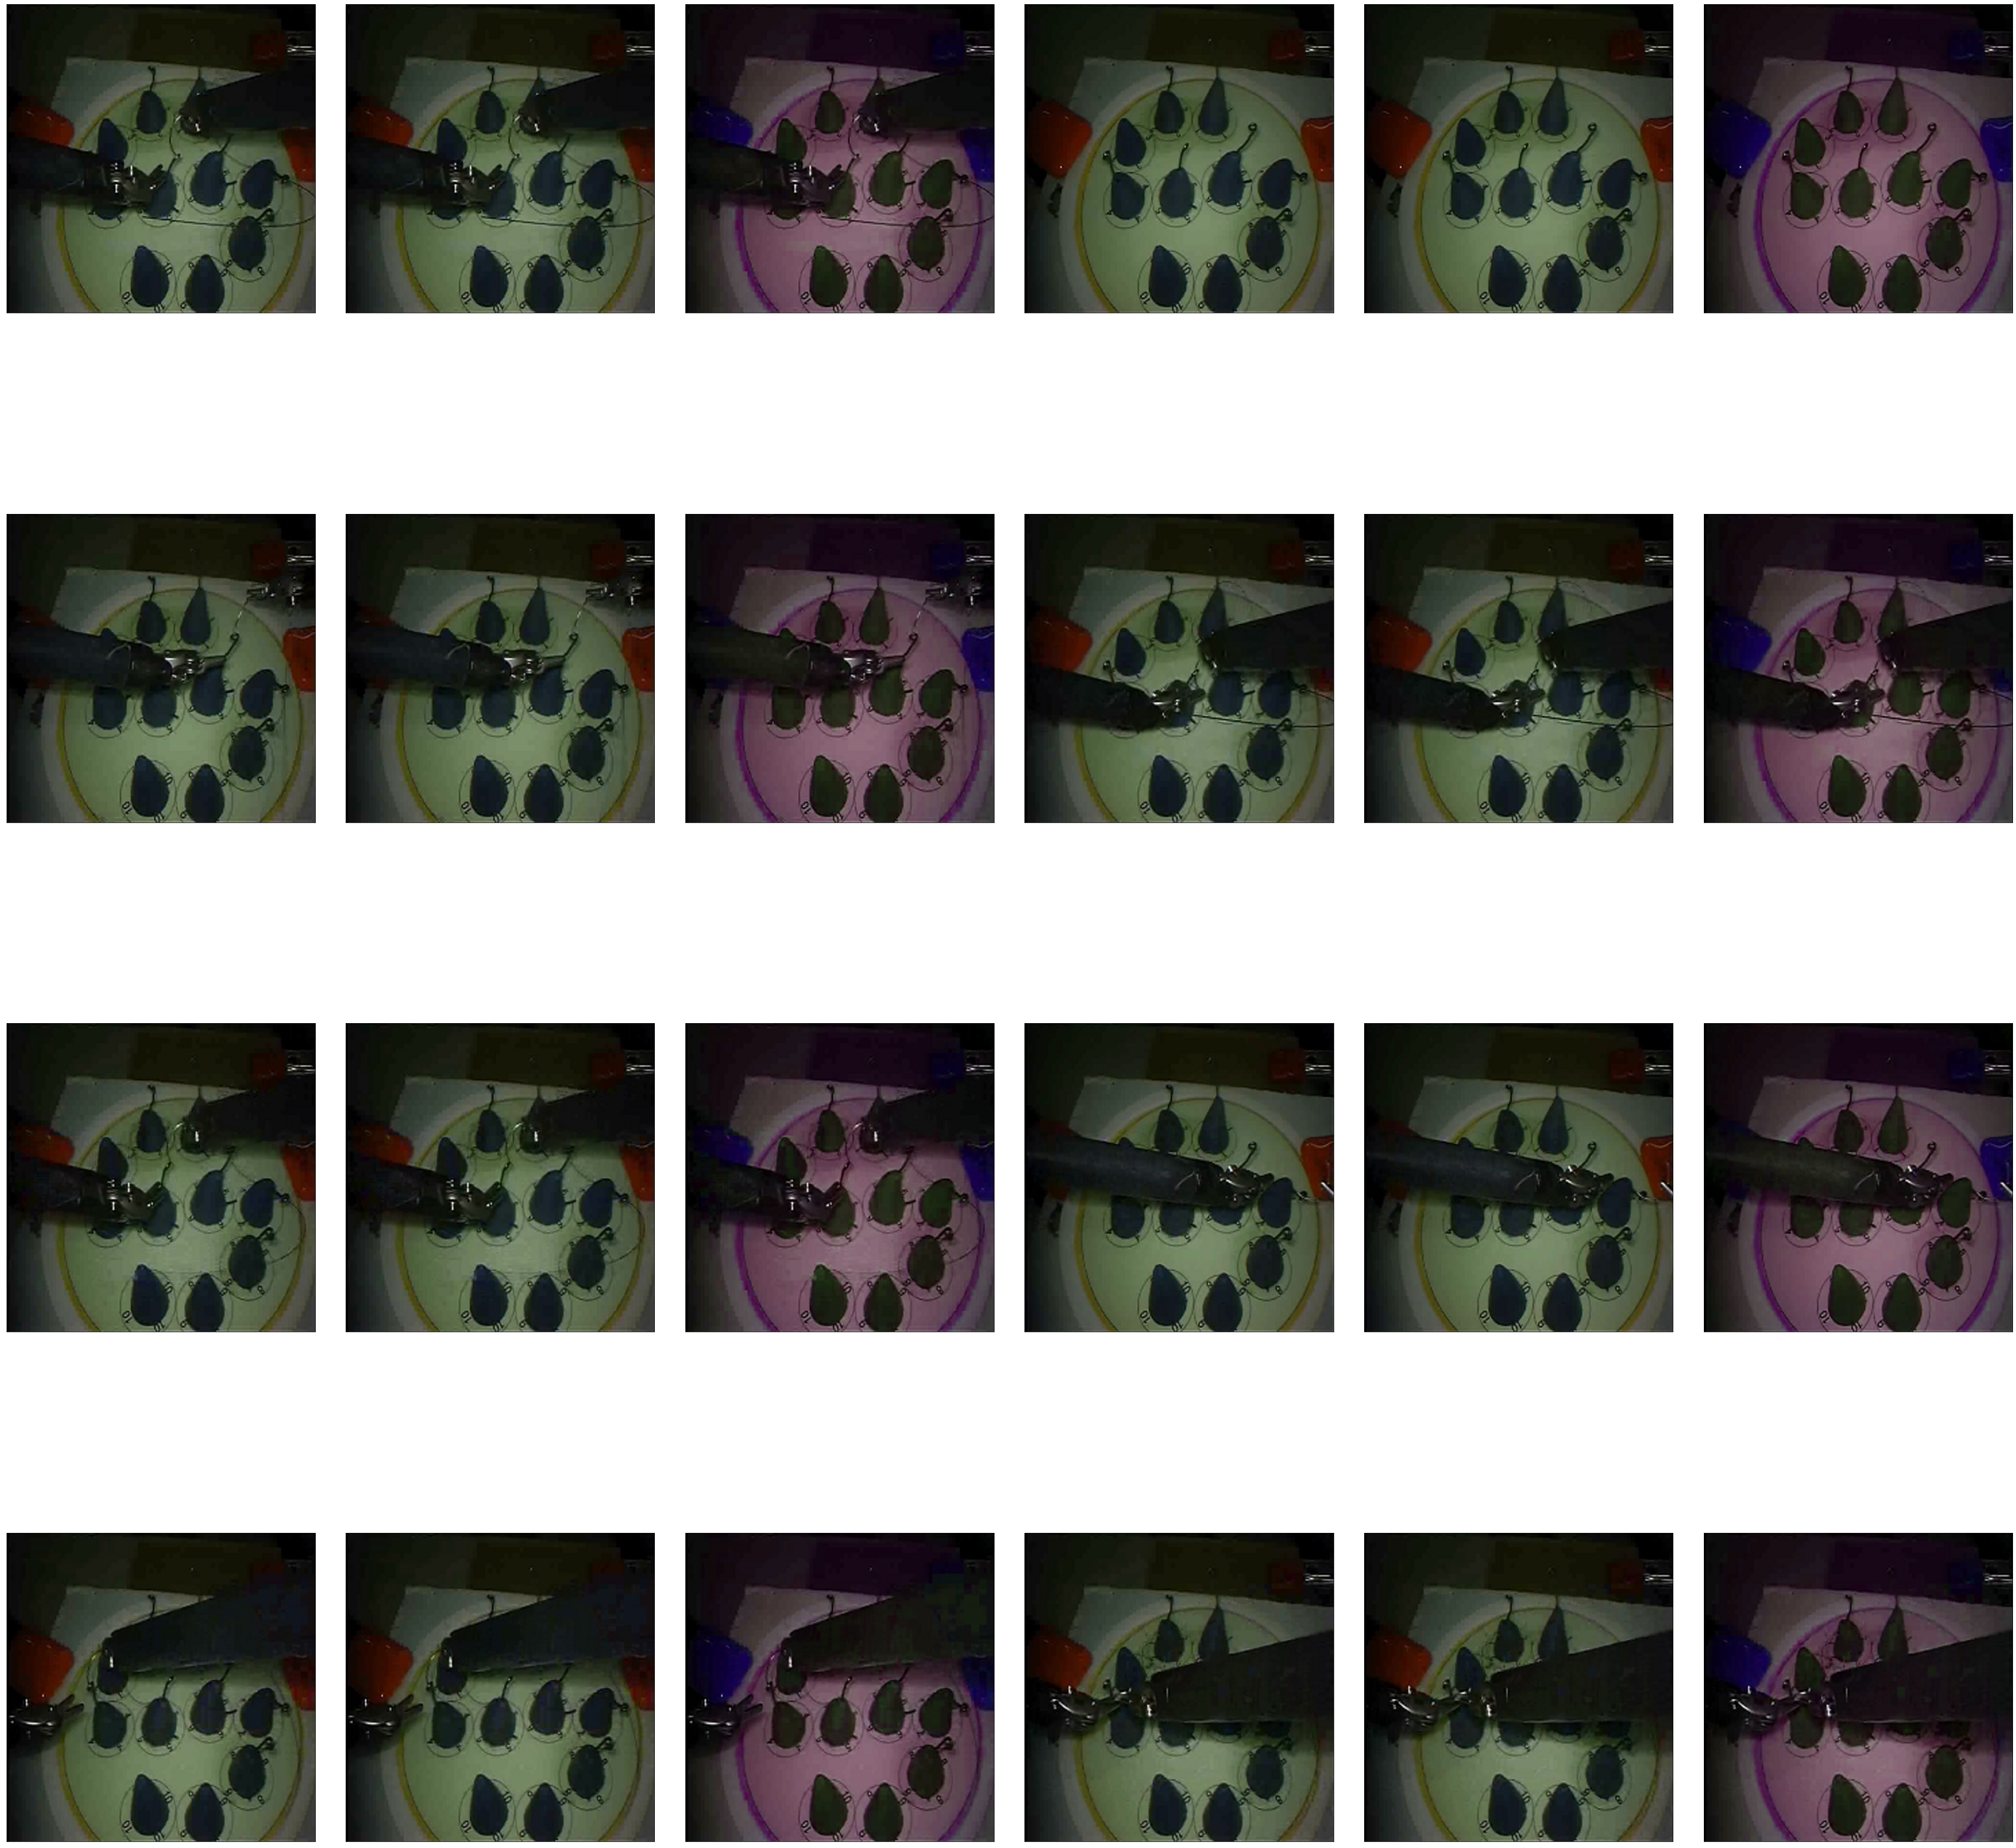

In [18]:

#x_batch, y_batch,_ = trainflow.next()
plot_imagesT((x_batch[:,:,:,0:3]*255).astype(np.uint8),(x_batch_right[:,:,:,0:3]*255).astype(np.uint8), np.squeeze(y_batch*255), cls_pred=None, smooth=True, filename='test.png')

In [19]:
y_batch.shape

(8, 224, 224, 3)

In [20]:

imgs_test=[imgs_test[img] for img in ids_val]
imgs_mask_test=[imgs_mask_test[img] for img in ids_val]

#ids_val_batch = np.random.choice(len(imgs_test), size=val_num, replace=False)
imgs_test=np.array(imgs_test)
imgs_mask_test=np.array(imgs_mask_test)
#imgs_mask_test =imgs_mask_test[ids_val_batch]


In [21]:

imgs_train=[imgs_train[img] for img in ids_train]
imgs_mask_train=[imgs_mask_train[img] for img in ids_train]


imgs_train=np.array(imgs_train)
imgs_mask_train=np.array(imgs_mask_train)

In [22]:
trainflow=datagen.flow(imgs_train, imgs_mask_train, batch_size=1)
x_batch,x_batch_right, y_batch,_ = trainflow.next()


In [23]:
y_batch.shape

(1, 224, 224, 3)

In [24]:
batchsize=10
 
Traindatagen =CustomImageDataGenerator(netparam,training=1)

Validdatagen= CustomImageDataGenerator(netprameval,training=1)


In [25]:
trainflow=Traindatagen.flow(imgs_train, imgs_mask_train, batch_size=1)
x_batch,x_batch_right, y_batch,_ = trainflow.next()

In [26]:
y_batch.shape


(1, 224, 224, 11)

In [27]:


def train_generator():
    trainflow=Traindatagen.flow(imgs_train, imgs_mask_train, batch_size=batchsize)
    while True:
        x_batch,x_batch_right, y_batch,_ = trainflow.next()
        #pdb.set_trace()
        yield [x_batch,x_batch_right], y_batch


In [28]:

def valid_generator():
    validflow=Validdatagen.flow(imgs_test, imgs_mask_test, batch_size=batchsize)
    while True:
        x_batch,x_batch_right, y_batch,_ = validflow.next()
#        pdb.set_trace()
        yield [x_batch, x_batch_right],y_batch


In [29]:

model =YnetResNet(netparam)
filename='YnetResNet2017_'+netparam.task+'_v'+d1+d2+'.hdf5'
logdirs='%s%s'%(splitext(filename)[0],'logs')


c:\Users\ianre\Desktop\coda\streoscene\py-env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [30]:
if  (os.path.exists(filename)):
    print("Loading model from disk")
    model.load_weights(filename, by_name=False)


In [31]:
model.summary()

plot_model(model, to_file='%s%s'%(splitext(filename)[0],'model2017.png'))

Model: "RESNetU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                            

In [32]:
tensorboard = TensorBoard(log_dir=logdirs)
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=7,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath=filename,
                             save_best_only=True,
                             save_weights_only=True),
             tensorboard]

In [33]:
history =model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(imgs_train)) / float(netparam.batch_size)),
                    epochs=netparam.nb_epoch,
                    use_multiprocessing = True,
                    max_queue_size=50, 
                    workers=4,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(imgs_test)) / float(netparam.batch_size)))

C:\Users\ianre\AppData\Local\Temp\ipykernel_10380\1909035800.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(generator=train_generator(),


Epoch 1/40


Exception in thread Thread-4:
Traceback (most recent call last):
  File "C:\Users\ianre\AppData\Local\Programs\Python\Python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "C:\Users\ianre\AppData\Local\Programs\Python\Python39\lib\threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ianre\Desktop\coda\streoscene\py-env\lib\site-packages\keras\utils\data_utils.py", line 885, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\Users\ianre\Desktop\coda\streoscene\py-env\lib\site-packages\keras\utils\data_utils.py", line 875, in pool_fn
    pool = get_pool_class(True)(
  File "C:\Users\ianre\AppData\Local\Programs\Python\Python39\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "C:\Users\ianre\AppData\Local\Programs\Python\Python39\lib\multiprocessing\pool.py", line 212, in __init__
    self._repopulate_pool()
  F

In [ ]:
histfile='%s%s'%(splitext(filename)[0],'_hist')
with open(histfile, 'wb') as f: 
    pickle.dump([history.history], f)

# Evaluation 

In [32]:
fr_num=20
img_left=imread(imgs_test[fr_num][0])
img_right=imread(imgs_test[fr_num][1])
img_left = img_left.astype('float32')
img_right = img_right.astype('float32')
img_left/=255.
img_right/=255.
img_left =cv2.resize(img_left, (224,224))
img_right =cv2.resize(img_right, (224,224))
img_right=np.reshape(img_right,(-1,img_left.shape[0],img_left.shape[1],img_left.shape[2]))
img_left=np.reshape(img_left,(-1,img_left.shape[0],img_left.shape[1],img_left.shape[2]))
pred_y_batch = model.predict([img_left, img_right], batch_size=4,verbose=1)
with open('labels_2017.json') as json_file:
    dataf = json.load(json_file)


1/1 [==============================] - 1s 1s/step


In [33]:
def convert_color(data,im, tasktype):
   # pdb.set_trace()
    im=np.squeeze(im)
    if tasktype.task=='all':
        out1 = (np.zeros((im.shape[0],im.shape[1])) ).astype(np.uint8)
        out2 = (np.zeros((im.shape[0],im.shape[1])) ).astype(np.uint8)
        out3 = (np.zeros((im.shape[0],im.shape[1])) ).astype(np.uint8)
        for label_info,index in zip(data['instrument'],range(0,np.shape(data['instrument'])[0]+1)):
            rgb=label_info['color'][0]
            if np.sum(rgb)==0:
                continue
            temp=im[:,:,index-1]
            temp=temp.astype(np.float)
            #temp =cv2.resize(temp,(224,224),interpolation=cv2.INTER_CUBIC)
            match_pxls = np.where(temp > 0.2)
            out1[match_pxls] = rgb
            
        for label_info,index in zip(data['parts'],range(np.shape(data['instrument'])[0],np.shape(data['instrument'])[0]+np.shape(data['parts'])[0])):
            rgb=label_info['color'][1]
            #pdb.set_trace()
            if np.sum(rgb)==0:
                continue
            temp=im[:,:,index-1]
            #print(index-1)
            temp=temp.astype(np.float)
            #temp =cv2.resize(temp,(224,224),interpolation=cv2.INTER_CUBIC)
            match_pxls = np.where(temp > 0.2)
            out2[match_pxls] = rgb
        out3=(im[:,:,index]>0.2)*255
        out=np.dstack((out1,out2,out3))
    if tasktype.task=='binary':
        out = (np.zeros((im.shape[0],im.shape[1])) ).astype(np.uint8)  
        out=(im>0.2)*255
    if tasktype.task=='parts':
        out = (np.zeros((im.shape[0],im.shape[1])) ).astype(np.uint8)
        for label_info,index in zip(data['parts'],range(0,np.shape(data['parts'])[0])):
            rgb=label_info['color'][1]
            if np.sum(rgb)==0:
                continue
            temp=im[:,:,index]
            temp=temp.astype(np.float)
            temp =cv2.resize(temp,(224,224),interpolation=cv2.INTER_CUBIC)
            match_pxls = np.where(temp > 0.2)
            out[match_pxls] = rgb
    if tasktype.task=='instrument':
        out = (np.zeros((im.shape[0],im.shape[1])) ).astype(np.uint8)
        for label_info,index in zip(data['instrument'],range(0,np.shape(data['instrument'])[0])):
            rgb=label_info['color'][0]
            if np.sum(rgb)==0:
                continue
            temp=im[:,:,index-1]
            temp=temp.astype(np.float)
            temp =cv2.resize(temp,(224,224),interpolation=cv2.INTER_CUBIC)
            match_pxls = np.where(temp > 0.2)
            out[match_pxls] = rgb
    return out.astype(np.uint8)


In [34]:
def mask_color_img(img,parts,binary, instr,fname='tr'):
    parts=np.squeeze(parts)
    binary=np.squeeze(binary)
    instr=np.squeeze(instr)
    T=[[127,201,127],
    [190,174,212],
    [253,192,134],
    [255,255,153],
    [56, 108,176],
    [240,  2,127],
    [191, 91,23]]
    P=[[255,0,0],
    [0,255,0],
    [0,0,255]]
    gt_b=np.dstack((np.zeros((224, 224)).astype(np.uint8),np.zeros((224, 224)).astype(np.uint8),binary)).astype(np.uint8)
    draw_img_b = cv2.addWeighted(img,1,gt_b,0.8,0.5).astype(np.uint8)
    gt_inst= (np.zeros((img.shape[0],img.shape[1],3)) ).astype(np.uint8)
    for g in range(1,8):
        match_pxls = np.where(instr == (g)*32)
        gt_inst[match_pxls] = T[g-1]
        #print(T[g])
    draw_img_inst = cv2.addWeighted(img,1,gt_inst,0.5,0.5).astype(np.uint8)
    gt_part= (np.zeros((img.shape[0],img.shape[1],3)) ).astype(np.uint8)
    for g in range(1,4):
        match_pxls = np.where(parts == (g)*85)
        gt_part[match_pxls] = P[g-1]
        #print(T[g])
    draw_img_part = cv2.addWeighted(img,1,gt_part,1,0.5).astype(np.uint8)
    
    cv2.imwrite(fname+'_binary.png', gt_b[...,::-1])
    plt.imshow(draw_img_b)
    plt.show()
    cv2.imwrite(fname+'_inst.png', gt_inst[...,::-1])
    plt.imshow(draw_img_inst)
    plt.show()
    cv2.imwrite(fname+'_part.png', gt_part[...,::-1])
    plt.imshow(draw_img_part)
    plt.show()
    return

In [35]:
pred_y_batch=np.squeeze(pred_y_batch)
temp=convert_color(dataf,(pred_y_batch), netparam)

In [36]:
par='_'+(imgs_test[fr_num][0]).split('/')[-3][-1]+'_'+((imgs_test[fr_num][0]).split('/')[-1][:-4])

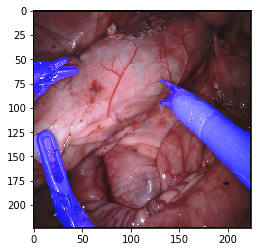

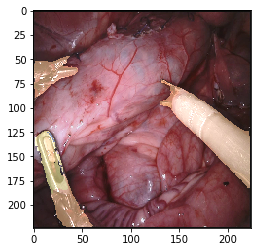

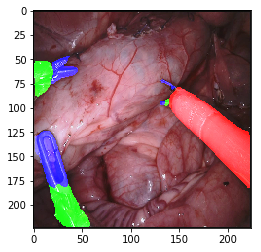

In [37]:
img=imread(imgs_test[fr_num][0])
mask_color_img(cv2.resize(img, (224,224)), temp[:,:,1],temp[:,:,2], temp[:,:,0],fname='pred'+par)